In [12]:
import os
from PIL import Image
import glob

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [2]:
def load_dataset():
    # Train set
    train_images = []
    train_labels = []
    i = 0
    for folder in glob.iglob("./dataset/train/*"):
        for file in glob.iglob(f"{folder}/*"):
            train_images.append(np.asarray(Image.open(file)))
            train_labels.append(np.asarray(i))
        i += 1
    
    # Test set
    test_images = []
    test_labels = []
    i = 0
    for folder in glob.iglob("./dataset/test/*"):
        for file in glob.iglob(f"{folder}/*"):
            test_images.append(np.asarray(Image.open(file)))
            test_labels.append(np.asarray(i))
        i += 1
        
    train_images = np.asarray(train_images)
    train_labels = to_categorical(train_labels, 10)
    
    test_images = np.asarray(test_images)
    test_labels = to_categorical(test_labels, 10)
    
    return train_images, test_images, train_labels, test_labels

In [3]:
x_train, x_test, y_train, y_test = load_dataset()

In [4]:
def normalize_images(img):
    #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_normalized = cv.normalize(img, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    #img_normalized = np.reshape(img_normalized, (96, 96, 1))
    return img_normalized

In [5]:
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

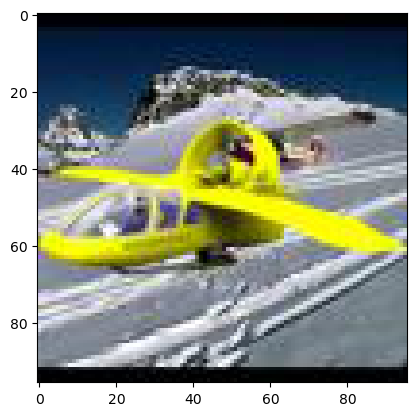

In [7]:
plt.imshow(x_train[100])

In [8]:
def build_classifier(dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))
    
    # Convolutional
    model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=dropout_rate))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=dropout_rate))
    
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=dropout_rate))
    
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=dropout_rate))
    
    model.add(layers.Conv2D(512, (3, 3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=dropout_rate))
    
    # Dense
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation="sigmoid"))
    model.add(layers.Softmax())
    
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    return model

In [10]:
# Build classifier model
model = build_classifier(dropout_rate=0.35)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 45, 45, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)       

In [13]:
early_stopping_monitor = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, callbacks=[early_stopping_monitor], validation_data=(x_test, y_test))

Epoch 1/100
157/157 [==============================] - 6s 39ms/step - loss: 1.5298 - categorical_accuracy: 0.9089 - val_loss: 1.6742 - val_categorical_accuracy: 0.7333
Epoch 2/100
157/157 [==============================] - 6s 37ms/step - loss: 1.5347 - categorical_accuracy: 0.9027 - val_loss: 1.7284 - val_categorical_accuracy: 0.6840
Epoch 3/100
157/157 [==============================] - 6s 37ms/step - loss: 1.5309 - categorical_accuracy: 0.9081 - val_loss: 1.6702 - val_categorical_accuracy: 0.7393
Epoch 4/100
157/157 [==============================] - 6s 36ms/step - loss: 1.5270 - categorical_accuracy: 0.9157 - val_loss: 1.6742 - val_categorical_accuracy: 0.7443
Epoch 5/100
157/157 [==============================] - 6s 36ms/step - loss: 1.5248 - categorical_accuracy: 0.9193 - val_loss: 1.6763 - val_categorical_accuracy: 0.7467
Epoch 6/100
157/157 [==============================] - 6s 36ms/step - loss: 1.5218 - categorical_accuracy: 0.9199 - val_loss: 1.6728 - val_categorical_accuracy:

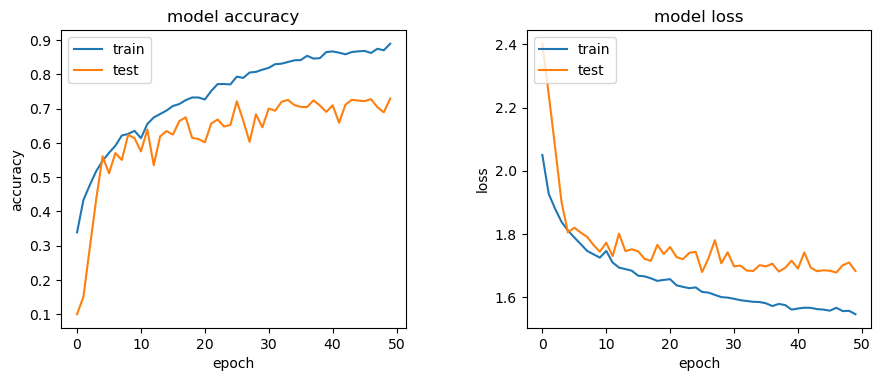

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Summarize history for accuracy
ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# Summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')

fig.tight_layout(pad=5.0)
plt.show()

In [14]:
model.save("./model_weights/initial_classifier/model2")

INFO:tensorflow:Assets written to: ./model_weights/initial_classifier/model2\assets
